In [5]:
from functools import partial
from pathlib import Path
import pickle

import numpy as np
import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
from flax import serialization
import optax
import pandas as pd

from common.cell import to_rgba, make_circle_masks
from common.pool import Pool
from common.nca import NCA
from common.vae import vae_dict, vae_loss
from common.utils import Config, load_face, visualize_nca, plot_loss, export_model

import tqdm
import hydra
from hydra.core.config_store import ConfigStore
from omegaconf import OmegaConf
import wandb
import matplotlib.pyplot as plt

In [7]:
# Load VAE
vae_dir = Path("/project/output/vae/2023-08-07_115619_895943")
vae_config = OmegaConf.load(vae_dir / ".hydra" / "config.yaml")

# Load list_attr_celeba.txt file into a pandas DataFrame
df_attr_celeba = pd.read_csv(vae_config.exp.attr_dir, sep="\s+", skiprows=1)
df_attr_celeba.replace(to_replace=-1, value=0, inplace=True) # replace -1 by 0

# Load list_landmarks_align_celeba.txt file into a pandas DataFrame
df_landmarks_align_celeba = pd.read_csv(vae_config.exp.landmarks_dir, sep="\s+", skiprows=1)

# Crop images from (218, 178) to (178, 178)
df_landmarks_align_celeba["lefteye_y"] = df_landmarks_align_celeba["lefteye_y"] - (218 - 178) / 2
df_landmarks_align_celeba["righteye_y"] = df_landmarks_align_celeba["righteye_y"] - (218 - 178) / 2
df_landmarks_align_celeba["nose_y"] = df_landmarks_align_celeba["nose_y"] - (218 - 178) / 2
df_landmarks_align_celeba["leftmouth_y"] = df_landmarks_align_celeba["leftmouth_y"] - (218 - 178) / 2
df_landmarks_align_celeba["rightmouth_y"] = df_landmarks_align_celeba["rightmouth_y"] - (218 - 178) / 2

# Resize images from (178, 178) to face_shape
df_landmarks_align_celeba /= 178/vae_config.exp.face_shape[0]

In [8]:
df_landmarks_align_celeba

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000001.jpg,24.808989,32.000000,38.112360,33.438202,27.685393,43.865169,26.247191,47.460674,38.831461,48.179775
000002.jpg,24.808989,32.359551,38.471910,33.078652,29.123596,41.348315,25.168539,47.101124,38.831461,47.820225
000003.jpg,27.325843,33.078652,37.393258,30.921348,38.831461,38.831461,26.606742,48.898876,35.235955,49.617978
000004.jpg,25.887640,33.438202,38.831461,31.640449,36.314607,42.426966,25.528090,48.539326,36.314607,47.101124
000005.jpg,23.730337,33.797753,40.269663,33.078652,30.921348,35.595506,25.528090,45.662921,37.393258,46.741573
...,...,...,...,...,...,...,...,...,...,...
202595.jpg,24.808989,32.719101,38.831461,32.719101,32.000000,43.146067,26.247191,47.101124,37.393258,47.820225
202596.jpg,24.089888,33.078652,39.550562,33.078652,30.561798,43.505618,23.730337,46.741573,39.550562,46.741573
202597.jpg,24.808989,32.719101,38.471910,32.719101,33.078652,42.067416,24.449438,47.101124,39.191011,47.820225
202598.jpg,24.808989,32.719101,38.831461,32.719101,32.359551,42.067416,25.528090,47.820225,38.112360,47.101124


In [4]:
dataset_size = df_attr_celeba.shape[0]
dataset_size = 10
if vae_config.exp.grayscale:
    dataset_phenotypes_target = np.zeros((dataset_size, *vae_config.exp.face_shape, 1))
else:
    dataset_phenotypes_target = np.zeros((dataset_size, *vae_config.exp.face_shape, 3))
for i, (index, _,) in tqdm.tqdm(enumerate(df_attr_celeba.iterrows()), total=dataset_size):
    dataset_phenotypes_target[i] = load_face(vae_config.exp.dataset_dir + index, vae_config.exp.face_shape, vae_config.exp.grayscale)
    if i == dataset_size-1:
        break

 90%|█████████ | 9/10 [00:07<00:00,  1.18it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


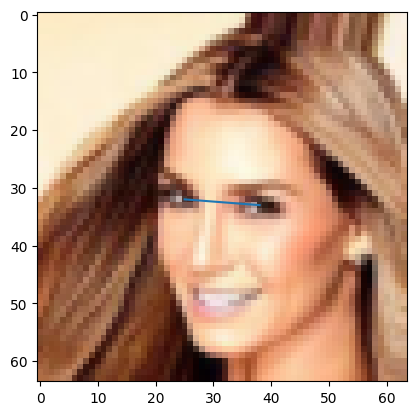

In [14]:
plt.imshow(dataset_phenotypes_target[0])
plt.plot([25, 38], [32, 33])

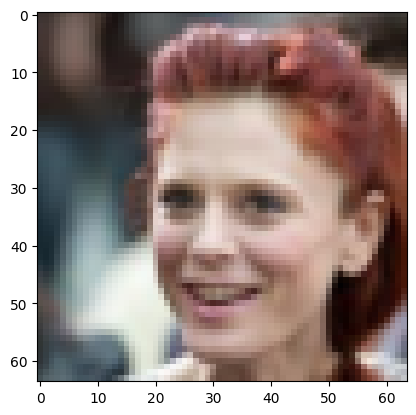

In [15]:
plt.imshow(dataset_phenotypes_target[1])